In [1]:
import sympy as sym
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64",True) # Don't use double for this to be more pronounced
jax.config.update("jax_default_device", jax.devices()[1])
jax.config.update("jax_debug_nans", True)
from sympy import factorial
from sympy.plotting import plot
from sympy.series.series import series
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from KernelTools import vectorize_kfunc,dxx_k,make_block,eval_k
from scipy.special import factorial as scipy_fac


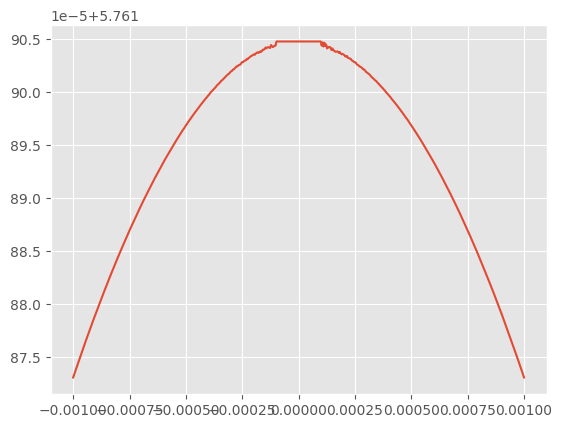

In [2]:
def get_matern(p,rho,eps = 1e-8):
    """
        Builds a Matern kernel function.

        Args:
            p (int): As used in smoothness nu = p + 1/2.
            rho (double): Length scale of the Matern kernel.

        Returns:
            function: This function returns the Matern kernel with smoothness p+1/2 and lengthscale rho.   
    """
    exp_multiplier = -jnp.sqrt(2 * p + 1)
    coefficients = jnp.array([scipy_fac(p + i) / (scipy_fac(i) * scipy_fac(p - i)) * (jnp.sqrt(8 * p + 4))**(p - i) for i in range(p + 1)])
    powers = jnp.arange(p,-1,-1)
    norm_cons = scipy_fac(p)/scipy_fac(2*p)
    def k(x,y):
        # True 
        d2 = jnp.sum((x-y)**2)/rho**2
        d = jnp.sqrt(d2+1e-100)
        true =  norm_cons*jnp.sum(coefficients * jnp.power(d,powers))*jnp.exp(exp_multiplier * d)
        #  Taylor
        nu = p + 1/2
        taylor = 1 + (nu/(2*(1-nu))*d2 + nu**2/(8*(2-3*nu+nu**2))*(d2)**2)
        return jnp.where(d2<eps, taylor, true)
    return k


k = get_matern(5,1.)


vkphi = vectorize_kfunc(dxx_k(dxx_k(k,0),1))
n = 500
zero = jnp.array([[0,0.]])
bound = 1e-3
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-bound,bound,n)]).T
plt.plot(grid[:,1],make_block(k,dxx_k,dxx_k)(zero,grid)[0])

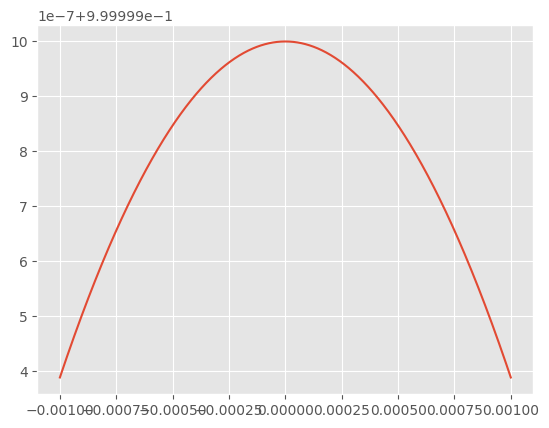

In [3]:
def setup_matern(p,eps = 1e-8):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)
    #S = series(sym.log(matern),d,0,2*p+1).removeO()
    S = series(matern,d,0,2*p+1).removeO()
    polyS = sym.Poly(S,d)
    asy_coeffs = polyS.coeffs()
    asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

    asy_powers = polyS.monoms()
    half_asy_powers = jnp.array(asy_powers)[:,0]//2

    def matern_p_factory(rho):
        def matern_func(x,y):
            d2 = jnp.sum((x-y)**2)/(rho**2)
            d = jnp.sqrt(d2 + 1e-100)
            true = jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
            #asymptotic = jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
            asymptotic = jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers))
            return jnp.where(d2<eps, asymptotic, true)
        return matern_func
    return matern_p_factory

k = setup_matern(5)(1.)

bound = 1e-3
grid = jnp.linspace(-bound,bound,1000)
values = vectorize_kfunc(k)(jnp.array([0.]),grid)[0]
plt.plot(grid,values)

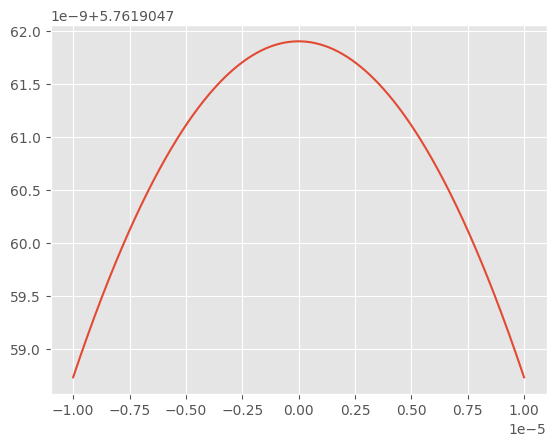

In [4]:
k = setup_matern(5,eps = 1e-5)(1.)

bound = 1e-2
grid = jnp.linspace(-bound,bound,1000)
zero = jnp.array([[0,0.]])
bound = 1e-5
grid = jnp.vstack([jnp.zeros(n),jnp.linspace(-bound,bound,n)]).T

plt.plot(grid[:,1],make_block(k,dxx_k,dxx_k)(zero,grid)[0])
plt.show()

In [5]:
def setup_matern(p,eps = 1e-8):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)
    #S = series(sym.log(matern),d,0,2*p+1).removeO()
    S = series(matern,d,0,2*p+1).removeO()
    polyS = sym.Poly(S,d)
    asy_coeffs = polyS.coeffs()
    asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

    asy_powers = polyS.monoms()
    half_asy_powers = jnp.array(asy_powers)[:,0]//2

    def matern_p_factory(rho):
        def matern_func(x,y):
            d2 = jnp.sum((x-y)**2)/(rho**2) + 1e-50
            d = jnp.sqrt(d2 + 1e-100)
            true = jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
            #asymptotic = jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
            asymptotic = jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers))
            return jnp.where(d2<eps, asymptotic, true)
        return matern_func
    
    return matern_p_factory


k = setup_matern(5,eps = 1e-5)(0.3)


X_test = jax.random.normal(jax.random.PRNGKey(10),(500,2))

In [6]:
jnp.sum(jnp.isnan(make_block(k,dxx_k,dxx_k)(X_test,X_test)))

Array(0, dtype=int64)

In [7]:
jnp.sum(jnp.isnan(make_block(k,eval_k,dxx_k)(X_test,X_test)))

Array(0, dtype=int64)

In [8]:
base_kernel = setup_matern(4)
k_u = base_kernel(0.3)

dxx_k(k_u,0)(jnp.array([0.,0]),jnp.array([0.0, 1.]))

Array(0.49875066, dtype=float64)

In [9]:
make_block(k,dxx_k,dxx_k)(grid,grid)[0][1] - make_block(k,dxx_k,dxx_k)(grid,grid)[0][0]

Array(-6.98037184e-11, dtype=float64)

In [10]:
p = 4
eps = 1e-5


exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [
    (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
    * (sym.sqrt(8 * p + 4))**(p - i) 
    for i in range(p + 1)]
powers = list(range(p,-1,-1))

jax_coefficients = jnp.array(list(map(float,coefficients)))
jax_powers = jnp.array(powers)
jax_exp_multiplier = float(exp_multiplier)

d = sym.symbols('d')
matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)
S = series(sym.log(matern),d,0,2*p+1).removeO()
polyS = sym.Poly(S,d)
asy_coeffs = polyS.coeffs()
asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

asy_powers = polyS.monoms()
half_asy_powers = jnp.array(asy_powers)[:,0]/2

def matern_p_factory(rho):
    def matern_func(x,y):
        d2 = jnp.sum((x-y)**2 + 1e-50)/(rho**2)
        d = jnp.sqrt(d2+ 1e-5)
        true = jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
        asymptotic = jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
        return true#jnp.where(d2<eps, asymptotic, true)
    return matern_func


In [11]:
def alt_func(x,y):
    d2 = jnp.sum((x-y)**2)+1e-40
    #return jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
    return jnp.power(d2,half_asy_powers)[2]

In [12]:
dxx_k(dxx_k(alt_func,0),1)(zero[0],zero[0])

Array(24., dtype=float64)

In [13]:
def op1(k,index):
    return jax.grad(jax.grad(k,index),index)

In [14]:
from KernelTools import get_selected_grad


In [15]:
def d2_selected_k(k,index,selected):
    return get_selected_grad(get_selected_grad(k,index,selected),index,selected)

d2_selected_k(d2_selected_k(alt_func,0,0),1,0)(zero[0],zero[0]+3.3e-52)

Array(24., dtype=float64)

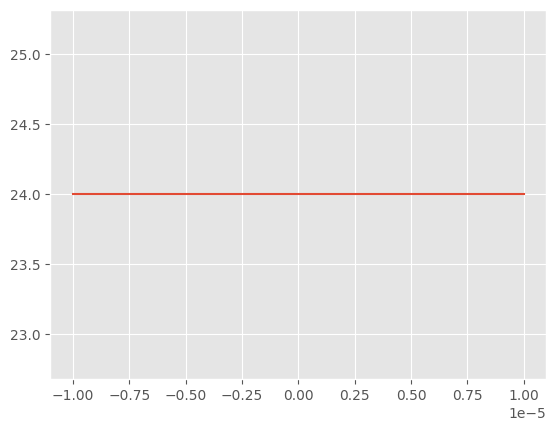

In [16]:
plt.plot(grid[:,1],make_block(alt_func,dxx_k,dxx_k)(zero,grid)[0])

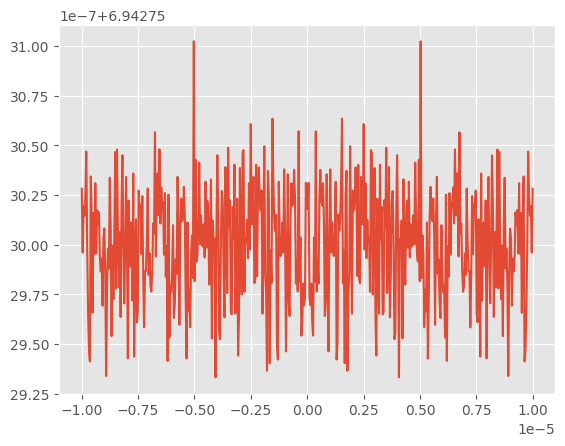

In [17]:
k = matern_p_factory(1.)

plt.plot(grid[:,1],make_block(k,dxx_k,dxx_k)(zero,grid)[0])